In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
# Find most recent date
last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

# Exploratory Climate Analysis

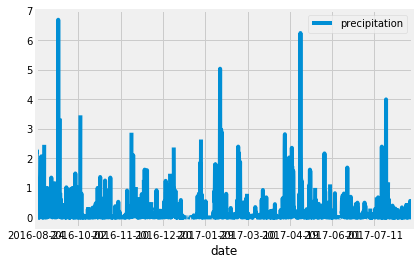

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

one_year_ago=dt.datetime(2017,8,23)-dt.timedelta(days=365)

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores
results=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df=pd.DataFrame(results,columns=['date','precipitation'])

# Sort the dataframe by date
df=df.sort_values(by=['date'])
df.set_index('date',inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data

df.plot(x_compat=True)


![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
Station_count=session.query(Station.station).count()
Station_count

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
Active=session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).order_by(desc(func.count(Measurement.tobs))).all()
Active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
Temp=session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).all()
Temp
# highest temperature recorded, and average temperature most active station?


[(53.0, 87.0, 73.09795396419437)]

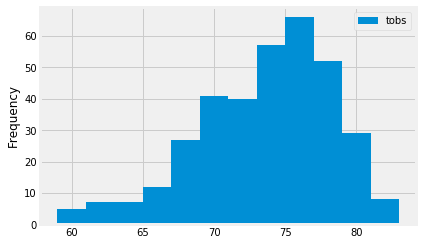

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
choose=session.query(Measurement.tobs).filter(Measurement.station==Active[0][0]).filter(Measurement.date>=one_year_ago).all()
choose_df=pd.DataFrame(choose,columns=['tobs'])


choose_df.plot.hist(bins=12)


In [16]:
from flask import Flask, jsonify
from werkzeug.wrappers import Request, Response



In [17]:
app = Flask(__name__)

In [18]:
@app.route("/")
def home():
    """List all api routes available"""
    return(f"Available Routes:<br/>"
        f"<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"Convert the query results to a Dictionary using date as the key and prcp as the value.<br/>"
        f"/api/v1.0/stations<br/>"
        f"Return a JSON list of stations from the dataset.<br/>"
        f"/api/v1.0/tobs<br/>"
        f"Return a JSON list of Temperature Observations (tobs) for the previous year.<br/>"
        f"/api/v1.0/start<br/>"
        f"When given the start only, calculate TMIN, TAVG, and TMAX for all dates greater than and equal to the start date.<br/>"
        f"/api/v1.0/start/end<br/>"
        f"When given the start and the end date, calculate the TMIN, TAVG, and TMAX for dates between the start and end date inclusive.<br/>")



In [19]:
@app.route("/api/v1.0/precipitation")
def prc():
    """Return precipitation"""
    precipitation=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=one_year_ago).order_by(Measurement.date)
    re=[]
    for row in precipitation:
        rows={}
        rows['date']=row[0]
        rows['prcp']=row[1]
        re.append(rows)
    return jsonify(re)


In [20]:
@app.route("/api/v1.0/stations")
def s():
    """return stations"""
    all_stations=session.query(Station.station).all()
    return jsonify(all_stations)



In [21]:
@app.route("/api/v1.0/tobs")
def t():
    """return tobs"""
    tobs=session.query(Measurement.date,Measurement.tobs).filter(Measurement.date>=one_year_ago).order_by(Measurement.date)
    ret=[]
    for row in tobs:
        rows={}
        rows['date']=row[0]
        rows['prcp']=row[1]
        ret.append(rows)
    return jsonify(ret)


In [22]:
@app.route('/api/v1.0/<start>') 
def st(start=None):
    """return tobs of certain time period"""
    start_tobs=session.query(Measurement.tobs).filter(Measurement.date.between(start,'2017-08-23')).all()
    start_tobs_df=pd.DataFrame(start_tobs)
    TMIN=start_tobs_df["tobs"].min()
    TMAX=start_tobs_df["tobs"].max()
    TAVG=start_tobs_df["tobs"].mean()
    return jsonify(TMIN,TMAX,TAVG)

In [23]:
@app.route('/api/v1.0/<start>/<end>') 
def se(start=None,end=None):
    """return tobs of certain time period"""
    both_tobs=session.query(Measurement.tobs).filter(Measurement.date.between(start,end)).all()
    both_tobs_df=pd.DataFrame(both_tobs)
    TMIN=both_tobs_df["tobs"].min()
    TMAX=both_tobs_df["tobs"].max()
    TAVG=both_tobs_df["tobs"].mean()
    return jsonify(TMIN,TMAX,TAVG)

In [24]:
# if __name__=="__main__":
#     from werkzeug.serving import run_simple
#     run_simple('localhost', 9000, app)

    

![precipitation](Images/station-histogram.png)

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp=calc_temps('2017-05-29','2017-06-07')
trip_temp

[(71.0, 77.45901639344262, 81.0)]

<BarContainer object of 1 artists>

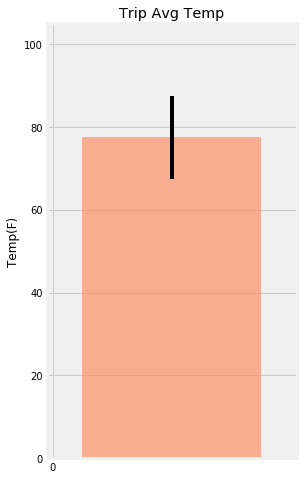

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig,ax=plt.subplots(figsize=plt.figaspect(2.))
x=1
ax.set_ylabel("Temp(F)")
ax.set_title("Trip Avg Temp")
ax.set(xticks=range(x))
ax.margins(.2, .2)
ax.bar(x,trip_temp[0][1],yerr=trip_temp[0][2]-trip_temp[0][0],color='coral', width=1.5,align="center",alpha=0.6)



In [28]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
select=[Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]
total_rainfall=session.query(*select).filter(Measurement.station==Station.station).filter(Measurement.date>='2017-05-29').filter(Measurement.date<='2017-06-07').group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(total_rainfall)

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 2.12), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.85), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.7999999999999999), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.42), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.30000000000000004), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.26), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


## Optional Challenge Assignment

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date='2017-05-29'
end_date='2017-06-07'
# Use the start and end date to create a range of dates
Date_range=pd.date_range(start_date,end_date)
# Stip off the year and save a list of %m-%d strings
month_day=Date_range.strftime('%m-%d')
# Loop through the list of %m-%d strings and calculate the normals for each date
normals=[]
for day in month_day:
    normals.append(*daily_normals(day))
normals

[(64.0, 74.19607843137256, 80.0),
 (69.0, 74.33333333333333, 81.0),
 (68.0, 74.4, 81.0),
 (64.0, 74.6140350877193, 81.0),
 (65.0, 74.4, 81.0),
 (65.0, 74.03448275862068, 80.0),
 (65.0, 73.81818181818181, 81.0),
 (68.0, 74.85454545454546, 81.0),
 (70.0, 75.17543859649123, 80.0),
 (68.0, 75.07142857142857, 81.0)]

In [31]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
Trip_df=pd.DataFrame(normals,columns=['tmin','tavg','tmax'])
Trip_df['date']=Date_range
Trip_df.set_index(['date'],inplace=True)
Trip_df.head()

,tmin,tavg,tmax
date,,,
2017-05-29,64.0,74.196078,80.0
2017-05-30,69.0,74.333333,81.0
2017-05-31,68.0,74.400000,81.0
2017-06-01,64.0,74.614035,81.0
2017-06-02,65.0,74.400000,81.0


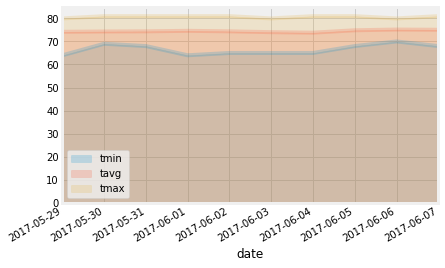

In [32]:
# Plot the daily normals as an area plot with `stacked=False`
Trip_df.plot(kind='area',stacked=False,x_compat=True,alpha=.2)

In [ ]:
if __name__=="__main__":
    from werkzeug.serving import run_simple
    run_simple('localhost', 9000, app)


 * Running on http://localhost:9000/ (Press CTRL+C to quit)
127.0.0.1 - - [21/Nov/2019 00:05:05] "GET /api/v1.0/2017-05-29 HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2019 00:05:12] "GET / HTTP/1.1" 200 -
